In [7]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load dataset

In [4]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 4200 images belonging to 20 classes.
Found 1800 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# Resnet50

In [3]:
input_layer = K.Input(shape=(160,160,3))
resnet_model = K.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in resnet_model.layers[:150]:
    layer.trainable = False
for i, layer in enumerate(resnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [4]:
METRICS = [
      K.metrics.BinaryAccuracy(name='accuracy'),
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),  
      K.metrics.AUC(name='auc')
]

In [5]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = resnet_model(inputs)
flat = K.layers.Flatten()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 20)                1024020   
                                                                 
Total params: 24,611,732
Trainable params: 11,014,164
Non-trainable params: 13,597,568
_________________________________________________________________


C:\Python\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training

In [6]:
checkpoint_filepath = 'D:/RESEARCH/Circuit component recognition/'
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_dataset,
                    epochs = 25,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/25
66/66 [==============================] - 528s 8s/step - loss: 3.2170 - accuracy: 0.9537 - precision: 0.5955 - recall: 0.2286 - auc: 0.8287 - val_loss: 8.3882 - val_accuracy: 0.9239 - val_precision: 0.1097 - val_recall: 0.0733 - val_auc: 0.6133
Epoch 2/25
66/66 [==============================] - 521s 8s/step - loss: 0.9865 - accuracy: 0.9725 - precision: 0.8378 - recall: 0.5583 - auc: 0.9716 - val_loss: 1.9954 - val_accuracy: 0.9579 - val_precision: 0.6437 - val_recall: 0.3522 - val_auc: 0.9155
Epoch 3/25
66/66 [==============================] - 526s 8s/step - loss: 0.7330 - accuracy: 0.9786 - precision: 0.8695 - recall: 0.6740 - auc: 0.9829 - val_loss: 1.3069 - val_accuracy: 0.9657 - val_precision: 0.7024 - val_recall: 0.5467 - val_auc: 0.9558
Epoch 4/25
66/66 [==============================] - 527s 8s/step - loss: 0.5484 - accuracy: 0.9829 - precision: 0.8967 - recall: 0.7443 - auc: 0.9908 - val_loss: 0.8372 - val_accuracy: 0.9744 - val_precision: 0.7829 - val_recall: 0.675

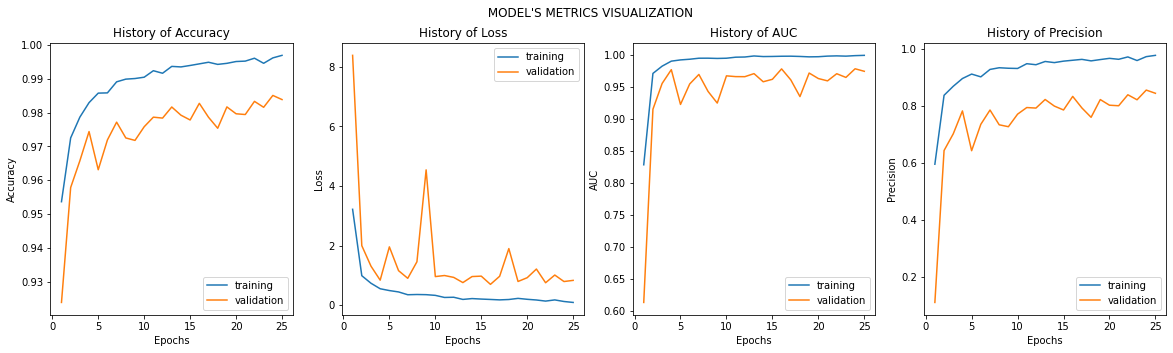

In [7]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
              )

In [8]:
model.save("resnet50.hdf5")

# Testing

In [5]:
# saved last model
model = K.models.load_model("resnet50.hdf5")
model.evaluate(test_dataset)

32/32 [==============================] - 133s 4s/step - loss: 2.0195 - accuracy: 0.9708 - precision: 0.7134 - recall: 0.6970 - auc: 0.9197


[2.019491195678711,
 0.9708499908447266,
 0.7134084105491638,
 0.6970000267028809,
 0.9196864366531372]

C:\Users\aroy8\AppData\Local\Temp/ipykernel_20672/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


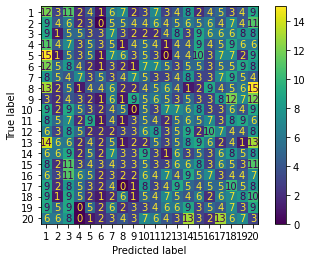

Classification Report
              precision    recall  f1-score   support

           1       0.07      0.12      0.09       100
           2       0.06      0.04      0.05       100
           3       0.03      0.05      0.04       100
           4       0.05      0.03      0.04       100
           5       0.07      0.05      0.06       100
           6       0.03      0.01      0.01       100
           7       0.03      0.03      0.03       100
           8       0.03      0.02      0.02       100
           9       0.16      0.09      0.11       100
          10       0.05      0.05      0.05       100
          11       0.04      0.04      0.04       100
          12       0.04      0.03      0.03       100
          13       0.05      0.05      0.05       100
          14       0.02      0.03      0.03       100
          15       0.08      0.08      0.08       100
          16       0.07      0.07      0.07       100
          17       0.05      0.05      0.05       100
     

In [13]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))